<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [3]:
# Import relevant packages for analysis
import stan as ps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from patsy import dmatrix, dmatrices
from patsy.contrasts import Treatment, Sum
import arviz as az

# Importing nest_asyncio is only necessary to run pystan in Jupyter Notebooks.
import nest_asyncio
nest_asyncio.apply();

In [20]:
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

# Bayesian estimation ordinal regression 

# Bayesian inference

<font size = "3"> Following the quick description of ordinal regression from a classical statistics perspective above its important to keep in mind that Bayesian analysis inferences are all derived from the application of Bayes rule $P(\theta \mid y) = \large \frac{P(y \mid \theta) \, P(\theta)}{P(y)}$ and as such while the following description of the Bayesian model is an equivalent to a ordinal regression, it is fundamentally different, because it uses fully probabilistic modelling and the inferences are not based on sampling distributions</font>
    
<font size = "1"> For a fuller description see the practicing Bayesian statistics markdown file within the Github repository.</font>

# Steps of Bayesian data analysis

<font size = "3"> Kruschke (2015) offers a step by step formulation for how to conduct a Bayesian analysis:

1. Identify the relevant data for the question under investigation.

2. Define the descriptive (mathematical) model for the data.

3. Specify the Priors for the model. If scientific research publication is the goal the priors must be accepted by a skeptical audience. Much of this can be achieved using prior predicitve checks to ascertain if the priors are reasonable.

4. Using Bayes' rule estimate the posterior for the parameters of the model using the likelihood and priors. Then interpret the posterior.

5. Conduct model checks. i.e. Posterior predcitive checks.</font> 

<font size = "1">This notebook will follow this approach generally.</font> 

#  Step 1 - Identify the relevant data for question under investigation

## Data overview and study description

Friendships can be formed in times of trauma. A classical example of this would be ristualistic hazing practices. Bastian, Jetten, and Ferris (2014) wanted to study such phenomena, by examining shared painful experiences to measures of cooperation and trust.

In order to study this, participants were assigned to either a pain or control condition. Within each condition, the particpants were split into small groups. The participants in the pain condition completed two different tasks designed to induce pain. These were cold pressor task and a wall sit. The tasks for the control condition varied but were all classed as purposeful, however, not painful.

Overall whats important for the analysis here is the main dependent variable. Which was a seven item likert scale to measure the bonding with other participants.


Bastian, Jetten and Ferris (2014) analysed the data using a one-way analysis of variance on the averaged score from the seven item likert scale. However, in this notebook is designed to demonstrate oridnal regression analyses that can be perfomed with this data set. A strong case will not be made here that such analyses maybe more appropriate due to issues of averaging likert scale data when the model types shown here exist. However, see, (Bürkner & Vuorre, 2019, Liddell & Kruschke, 2018, McElreath, 2020) for deeper arguments against the averaging of likert scales and the use of normal likelihood models to analyse the data. 

## Import data

In [33]:
# Specify url for raw data to be imported from the github repository.
url = 'https://raw.githubusercontent.com/ebrlab/Statistical-methods-for-research-workers-bayes-for-psychologists-and-neuroscientists/master/wip/Data/Bastian_Jetten_2014_Experiment_1.csv'

# Read data in pandas dataframe.
df = pd.read_csv(url)

In [34]:
# Print df 
df.head()

,subid,CONDITION,groupnumber,groupsize,subnumber,subage,subgender,gendercoded,subbornaus,subbornloc,...,group104,group105,group106,group107,task_intensity,task_unpleasantness,Threat_MEAN,Challenge_MEAN,Pos_PANAS,Neg_PANAS
0,6.1,0,6,3,1,20,1,0,0,Vietnam,...,3,4,3,3,1,1,1.000000,2.333333,2.4,1.0
1,6.2,0,6,3,2,25,2,0,0,Brunei,...,5,5,4,4,1,1,1.500000,4.166667,4.0,1.6
2,6.3,0,6,3,3,22,1,0,0,Malaysia,...,1,2,2,1,1,1,1.000000,2.000000,2.2,1.6
3,7.1,0,7,5,1,23,1,0,0,Malaysia,...,1,2,1,1,2,2,1.166667,3.000000,4.1,1.0
4,7.2,0,7,5,2,26,1,0,0,Singapore,...,4,5,3,4,3,4,2.500000,4.833333,4.3,2.4


In [35]:
cont_101 = df.loc[df['CONDITION'] == 0, 'group101']
exp_101 = df.loc[df['CONDITION'] == 1, 'group101']

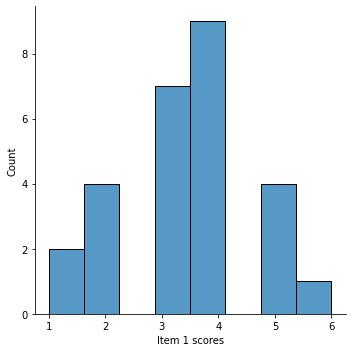

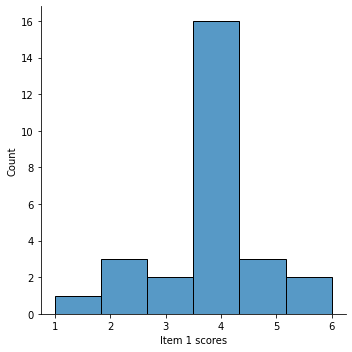

In [40]:
cont_101p = sns.displot(data = cont_101);
exp_101p = sns.displot(data = exp_101);

cont_101p.set( xlabel = "Item 1 scores", ylabel = "Count");
exp_101p.set( xlabel = "Item 1 scores", ylabel = "Count");

## The simplest model \begin{align*}
y_i &\sim Normal(\mu_i, \sigma)
\\ \mu_i &= \beta_0 + \beta_k x_k
\end{align*}

In [153]:
ordinalRegression1 = """

data{

int<lower = 1> N;
int<lower=1> D;
int<lower=2> K;
int<lower=1,upper=K>  y[N];
 row_vector[D] X[N];

int onlyprior; //
}

parameters{

vector[D] beta; // beta coeffiecnt including the intercept term
ordered[K-1] cutpoints;

}

model{

// Priors
beta[1] ~ normal(0,1);
beta[2] ~ normal(0,4);
cutpoints ~ normal(0,1);


if (!onlyprior){
for (i in 1:N){
     y[i] ~ ordered_logistic( X[i] * beta , cutpoints);
        }
   }     
}

generated quantities{
int yrep[N];

for (i in 1:N){
 yrep[i] = ordered_logistic_rng( X[i] * beta , cutpoints);
 }
}

"""

In [154]:
X = np.asarray(dmatrix(' ~ CONDITION', data = df))
update_list = []

for i in range(len(df)):
    update_data = int(df['group101'].iloc[i])
    update_list.append(update_data)
y = update_list   

In [155]:
data1 = {'N': len(df),
         'y': y,
         'D': int(np.shape(X)[1]),
         'K': int(max(np.unique(df.group101))),
         'X': X, 
         'onlyprior': 0}

In [156]:
sm = ps.build(ordinalRegression1, data = data1)

Building...



Building: 54.4s, done.Messages from stanc:


In [157]:
fit = sm.sample(num_chains = 4)

Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   6% (500/8000)
Sampling:  10% (800/8000)
Sampling:  14% (1100/8000)
Sampling:  22% (1800/8000)
Sampling:  44% (3500/8000)
Sampling:  65% (5200/8000)
Sampling:  86% (6900/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 8.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.89 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -32.2863, but should be greater than the previous element, -32.2863 (in '/tmp/httpstan_z5qmwkan/model_ias2rkxr.stan', line 31, column 5 to column 55)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this war

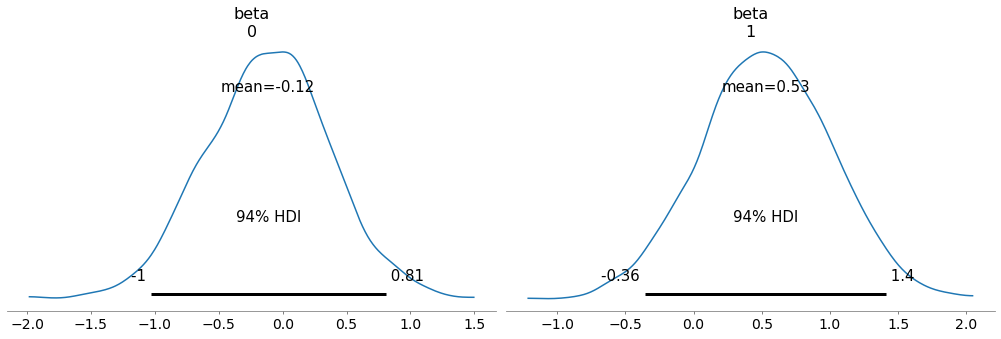

In [166]:
az.plot_posterior(fit, var_names = ['beta']);

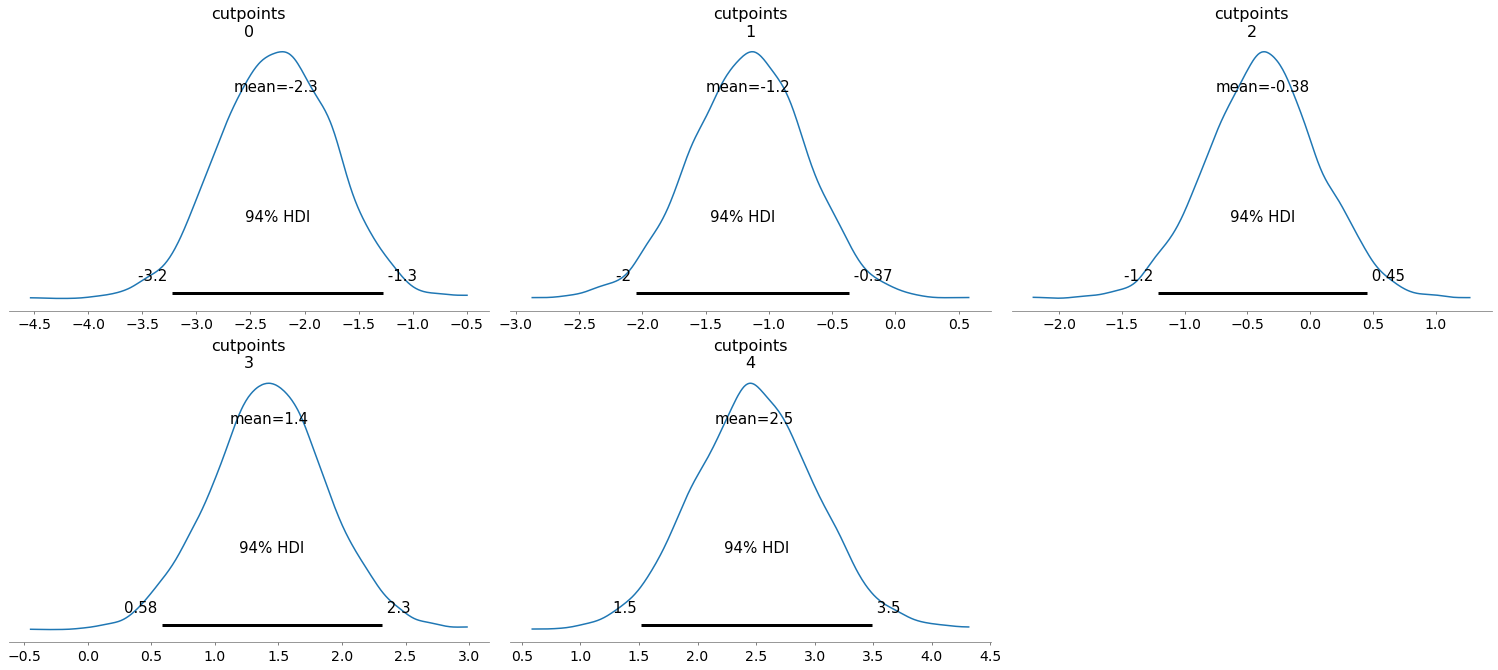

In [165]:
az.plot_posterior(fit, var_names = ['cutpoints']);

In [159]:
# Convert pystan fit object to IO for Arviz functions.
idata1 = az.from_pystan(posterior=fit, posterior_model=sm, posterior_predictive=['yrep'],observed_data= 'y')

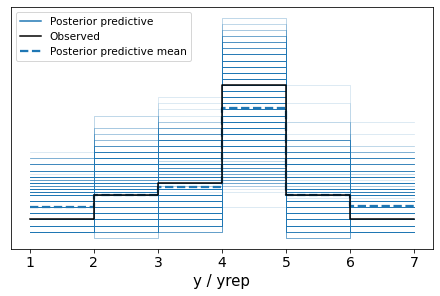

In [167]:
# Plot posterior simulated data sets for posterior predictive check
az.plot_ppc(idata1, data_pairs = {"y" : "yrep"}, num_pp_samples= 1000);

# References 

Bastian, B., Jetten, J., & Ferris, L. F. (2014). Pain as social glue: Shared pain increases cooperation.
Psychological Science, 25, 2079-2085.

Bürkner, P. C. (2017). brms: An R package for Bayesian multilevel models using Stan. Journal of statistical software, 80(1), 1-28.

Bürkner, P. C., & Vuorre, M. (2019). Ordinal regression models in psychology: A tutorial. Advances in Methods and Practices in Psychological Science, 2(1), 77-101.

Goodrich, B., Gabry, J., Ali, I., & Brilleman, S. (2018). rstanarm: Bayesian applied regression modeling via Stan. R package version, 2(4), 1758.
    
Hays, W.L. (1973) Statistics for the social sciences. Winston New York: Holt, Rinehart.

Kruschke, J. K., (2015). Doing bayesian data analysis: A tutorial with R, JAGS, and Stan. New york, NY: Academic Press.

Kruschke, J. K. (2018). Rejecting or accepting parameter values in Bayesian estimation. Advances in Methods and Practices in Psychological Science, 1(2), 270-280.
    
James, E. L., Bonsall, M. B., Hoppitt, L., Tunbridge, E. M., Geddes, J. R., Milton, A. L., & Holmes, E. A. (2015). Computer game play reduces intrusive memories of experimental trauma via reconsolidation-update mechanisms. Psychological Science, 26, 1201-1215.

Liddell, T. M., & Kruschke, J. K. (2018). Analyzing ordinal data with metric models: What could possibly go wrong?. Journal of Experimental Social Psychology, 79, 328-348.

Makowski, D., Ben-Shachar, M. S., Chen, S. H., & Lüdecke, D. (2019). Indices of effect existence and significance in the Bayesian framework. Frontiers in psychology, 10, 2767.

McElreath, R. (2020). Statistical rethinking: A Bayesian course with examples in R and Stan. Boca Raton: CRC Press.

Schad, D. J., Vasishth, S., Hohenstein, S., & Kliegl, R. (2020). How to capitalize on a priori contrasts in linear (mixed) models: A tutorial. Journal of Memory and Language, 110, 104038.

Vehtari, A., Gelman, A., Simpson, D., Carpenter, B., & Bürkner, P. C. (2019). Rank-normalization, folding, and localization: An improved $\widehat {R} $ for assessing convergence of MCMC. arXiv preprint arXiv:1903.08008.